In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imshow_collection
from scipy.ndimage.filters import convolve, gaussian_filter

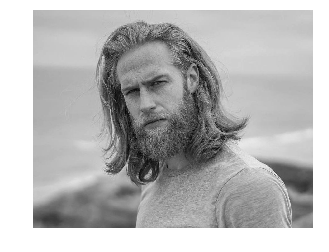

In [2]:
img = imread('16.jpg', as_gray=True)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

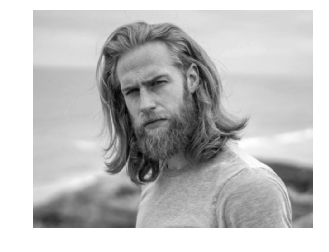

In [3]:
blur_img = gaussian_filter(img, 1.4)
plt.imshow(blur_img, cmap='gray')
plt.axis('off')
plt.show()

In [4]:
def canny_edges(image):
    # apply Sobel filters to get gradients
    h_g = convolve(image, [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) # horizontal gradient
    v_g = convolve(image, [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) # vertical gradient
    
    m = np.sqrt(np.square(h_g) + np.square(v_g))
    a = np.arctan2(v_g, h_g)
    '''
    Because gradient's direction (a) is always perpendicular to edges,
    so there can be four directions of edge:
        horizontal, vertical, left diagonal, right diagonal.
    * Horizontal lines denoted as 0 (0, 180 degrees)
    * Right diagonal lines (lead to right top corner) denoted as 1 (18, 53 degrees)
    * Vertical lines denoted as 2 (54, 90 degrees)
    * Left diagonal lines (lead to left top corner) denoted as 3
    '''
    q = (np.round(a*(5 / np.pi)) + 5) % 5
    
    # non-max suppression stage
    es = m.copy() # edges wuppressed
    es[:, [0, -1]] = 0
    es[[0, -1], :] = 0
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            tq = q[i, j] % 4
            if tq == 0:
                # suppose the line is horizontal
                if m[i, j] <= m[i, j-1] or m[i, j] <= m[i, j+1]:
                    # but if its magnitude smaller than magnitudes of horizontal neighbors,
                    #    then it is suppressed, cause its value non-max in horizontal direction
                    es[i, j] = 0
            if tq == 1: # suppose this point belongs to right diagonal line
                if m[i, j] <= m[i+1, j-1] or m[i, j] <= m[i-1, j+1]:
                    es[i, j] = 0
            if tq == 2: # suppose this point belongs to vertical line
                # so check vertical neighbors: 
                if m[i, j] <= m[i+1, j] or m[i, j] <= m[i-1, j]:
                    es[i, j] = 0
            if tq == 3: # suppose this point belongs to left diagonal line
                if m[i, j] <= m[i-1, j-1] or m[i, j] <= m[i+1, j+1]:
                    es[i, j] = 0
    # hysteresis thresholding
    #ht = es.max()*(4/5)
    #lt = es.min()+(es.min() + (1/3))
    lt = es.max()*(1/7)
    ht = lt + (es.max()*(2/7))
    print('High threshold:', ht, 'Low threshold:', lt)
    
    se = (es > ht).astype(np.uint8) # edges are strong if gradient value greater than high threshold (ht)
    we = (es > lt).astype(np.uint8) # weak edges
    te = se + we # strong edges denoted with 2, weak edges denoted with 1
    fe = se.copy()
    curpx = []
    # find weak pixels that near strong edge (within path 3x3)
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            if te[i, j] != 1:
                continue
            path = te[i-1:i+2, j-1:j+2]
            path_max = path.max()
            if path_max == 2:
                curpx.append((i, j))
                fe[i, j] = 1
    # extending strong edges
    while len(curpx) > 0:
        npx = []
        for x, y in curpx:
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if i == j == 0:
                        continue
                    i2 = i+x
                    j2 = j+y
                    if te[i2, j2] == 1 and fe[i2, j2] == 0:
                        npx.append((i2, j2))
                        fe[i2, j2] = 1
        curpx = npx
    return fe

e = canny_edges(blur_img)

High threshold: 0.40908379467658884 Low threshold: 0.13636126489219627


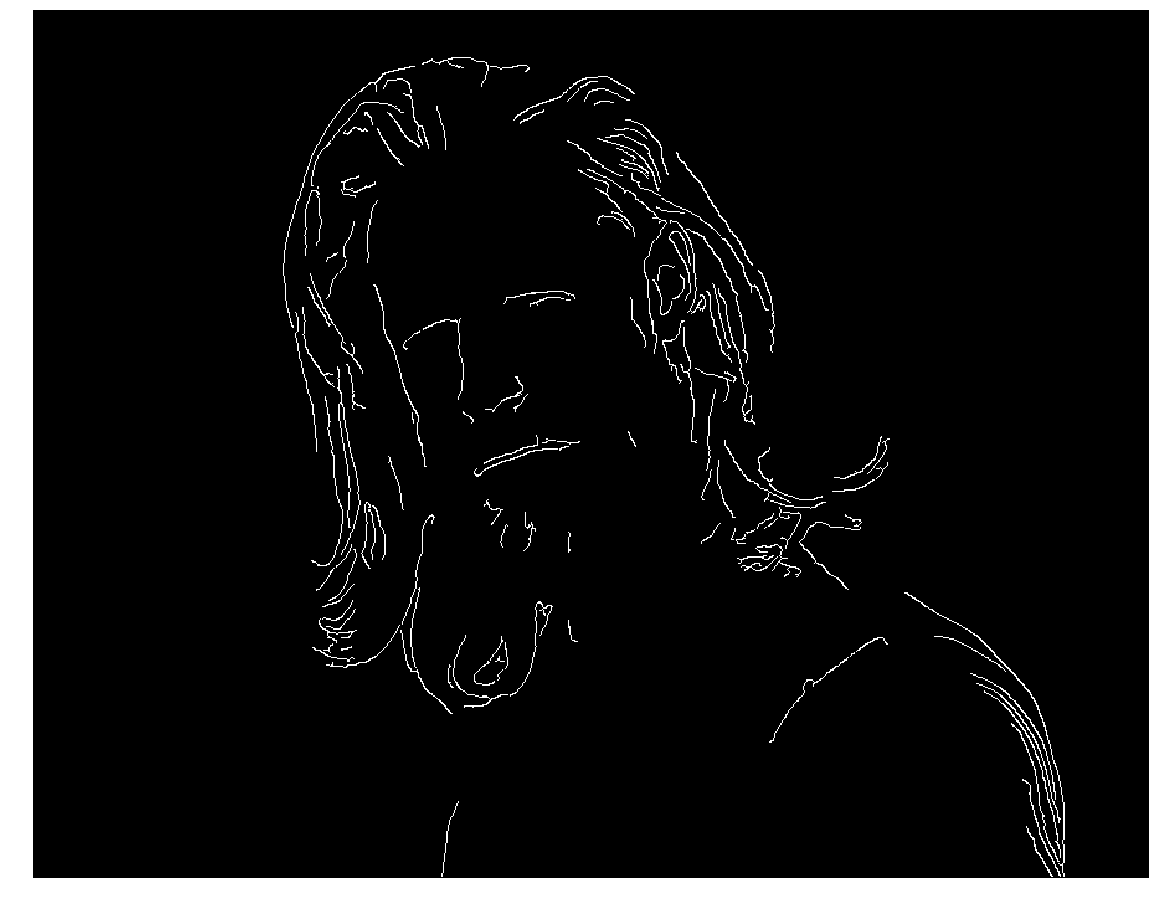

In [5]:
plt.figure(figsize=(20, 20))
plt.imshow(e, cmap='gray')
plt.axis('off')
plt.show()